<h1> Example: Split a CNN Model into Two Parts </h1>

To run this example, [Google Colab](https://colab.research.google.com) is a recommended choice.

First of all, Clone!

In [110]:
!git clone https://github.com/nrasadi/split-keras-tensorflow-model

Cloning into 'split-keras-tensorflow-model'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 13 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (13/13), done.


In [45]:
# Check if Colab is using gpu. 
# If not, Runtime tab -> Change runtime type -> Hardware Accelarator (GPU)
gpu_name = !nvidia-smi -L
print("GPU name: ", gpu_name[0]) if len(gpu_name) >= 1 else print("No GPU!")

GPU name:  GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-0875064e-f48e-ff55-29b6-019dd05b5f02)


In [112]:
from pathlib import Path
import os

import numpy as np
from tensorflow import keras
from tensorflow.keras import layers as KL
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import plot_model

%matplotlib inline

In [113]:
os.chdir("/content/split-keras-tensorflow-model")
import splitter

<h2> Load MNIST Dataset </h2>

It contains:
*   60000 train samples
*   10000 test samples



In [4]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# The data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float16") / 255
x_test = x_test.astype("float16") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# Convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


<h2> Visualize Dataset </h2>


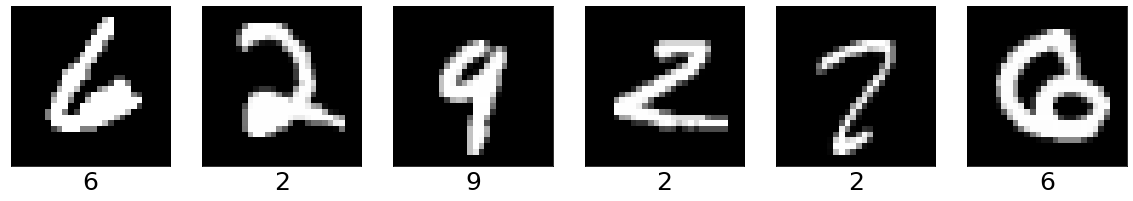

In [5]:
# Visualize dataset
plt.figure(figsize=(20,10))
sample_idx = np.random.randint(len(y_test), size=6)
for i in range(6):
  plt.subplot(161+i)
  plt.imshow(x_test[sample_idx[i]].reshape(28,28).astype(np.float), cmap='gray')
  # print("Label:", np.where(y_test[sample_idx] == 1)[0][0])
  # plt.axis("off")
  plt.xticks([]); plt.yticks([])
  plt.xlabel(str(np.where(y_test[sample_idx[i]] == 1)[0][0]), fontsize=25)
plt.show()

<h2> Design Digit Recognizer Model Architecture </h2>

<h3> Quantize the model </h3>

*   At first, I reduced the precision of weights and activations used in neural network to make the training process <b>faster</b>. 
*   It may introduce accuracy instability on real models however. Therefore it's better to use float32 or [tensorflow mixed precision policy](https://www.tensorflow.org/guide/keras/mixed_precision) instead!

<h3> Apply augmentation </h3>
 
To prevent <b>overfitting</b> and boost the accuracy of the model, I used a few -very simple- augmentation techniques before feeding images to the DNN.

*   All the following techniques are stochastic with the degree determined by 'factor'.
*   dropout: simulates noise or pixel drop.
*   zoom: applies zoom-in and zoom-out on images. (i.e. image scaling.)
*   translation, rotation: translates and rotates images.
*   contrast: modifies contrast of images.

<h3> Model architecture design </h3>

I designed a ResNet-like architecture, but pretty much simpler and with way too less parameters.

It consists of 4 blocks:

1. Conv(16)-Conv(32)-MaxPooling
2. ResBlock: Conv(32)-Conv(32)
3. ResBlock: Conv(32)-Conv(32)
4. Conv(64)-Dense(128)-Dense(10)

* I applied *ReLU6* activation on residual blocks and *ReLU* on others
* 20% dropout is applied on all conv blocks after batch normalization.
* 50% dropout is applied just before last dense layer (output).

<h3> Model construction </h3>

I used *RMSProp* as the optimzer and *categorical cross entropy* as the loss function.

In [55]:
# Quantize the network (Reduce precision of weights and activations to float16) 
K.set_floatx('float16')

# Apply some augmentation techniques on input images
factor = .1
augmentation = keras.Sequential(
    [
      KL.Dropout(0.001, name="drop_0"),
      KL.experimental.preprocessing.RandomZoom((-factor, factor), name="zoom"),
      KL.experimental.preprocessing.RandomTranslation((-factor, factor), (-factor, factor), name="translate",),
      KL.experimental.preprocessing.RandomRotation((-factor, factor), name="rotate"),
      KL.experimental.preprocessing.RandomContrast(factor, name="contrast"),
    ], name="augmentation"
)

# Define Conv Block
def Conv(tensor, filter, k=3, activation='relu', drop_rate=.2, maxpool=False, name_pos="0"):
    """Constructs Conv2D layers"""

    x = KL.Conv2D(filter, k, name="conv_"+name_pos, padding="same")(tensor)
    x = KL.BatchNormalization(name="bn_"+name_pos)(x)
    
    if activation.lower() == 'relu6':
      x = KL.Activation(tf.nn.relu6, name="relu6_"+name_pos)(x)
    elif activation.lower() == 'swish':
      x = KL.Activation(tf.nn.swish, name="swish_"+name_pos)(x)
    else:
      x = KL.Activation('relu', name="relu_"+name_pos)(x)
    
    x = KL.Dropout(drop_rate, name="drop_"+name_pos)(x)

    if maxpool:
      x = KL.MaxPooling2D(3, name="maxp_"+name_pos)(x)

    return x

act = "relu6"

# Block 0
inp = keras.Input(shape=input_shape, name="input")
x = augmentation(inp)

# Block 1
x = Conv(x, 16, name_pos="1")
x1 = Conv(x, 32, maxpool=True, name_pos="2")

# Block 2
x = Conv(x1, 32, activation=act, name_pos="3")
x = Conv(x, 32, activation=act, name_pos="4")
x2 = KL.add([x, x1], name="add_1")

# Block 3
x = Conv(x2, 32, activation=act, name_pos="5")
x = Conv(x, 32, activation=act, name_pos="6")
x3 = KL.add([x, x2], name="split") # Split point

# Block 4
x = Conv(x3, 64, activation=act, name_pos="7")
# x = KL.GlobalAveragePooling2D(name="globavgp")(x)
x = KL.Flatten(name="Flatten")(x)
x = KL.Dense(128, activation='relu', name="dense_1")(x)
x = KL.Dropout(0.5, name="last_drop")(x)
out = KL.Dense(10, name="output", activation="softmax")(x)

# Create model
model = keras.Model(inp, out, name="digit_recognizer")
model.summary()

# Construct DAG
model.compile(loss="categorical_crossentropy", optimizer="RMSProp", metrics=["accuracy"])

Model: "digit_recognizer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
augmentation (Sequential)       (None, 28, 28, 1)    0           input[0][0]                      
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 28, 28, 16)   160         augmentation[0][0]               
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 28, 28, 16)   64          conv_1[0][0]                     
___________________________________________________________________________________

<h2> Plot Graphical Visualization of the Network Architecture </h2>

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.647032 to fit



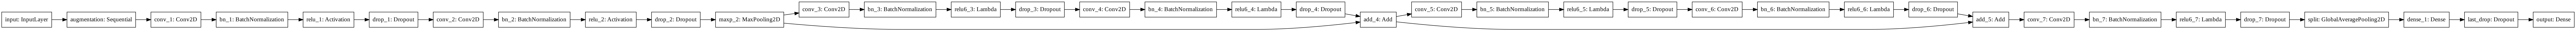

In [21]:
plot_model(model, rankdir='LR', dpi=600)

<h2> Train the Network </h2>

* Change batch size and number of epochs to fit best with the resources you have.

In [56]:
# Train the model
batch_size = 256
epochs = 200

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/200
211/211 [==============================] - 4s 17ms/step - loss: inf - accuracy: 0.1503 - val_loss: inf - val_accuracy: 0.0737
Epoch 2/200
211/211 [==============================] - 3s 16ms/step - loss: inf - accuracy: 0.1971 - val_loss: inf - val_accuracy: 0.1145
Epoch 3/200
211/211 [==============================] - 3s 16ms/step - loss: inf - accuracy: 0.2585 - val_loss: 4.8047 - val_accuracy: 0.2532
Epoch 4/200
211/211 [==============================] - 3s 16ms/step - loss: inf - accuracy: 0.3223 - val_loss: 1.4385 - val_accuracy: 0.5479
Epoch 5/200
211/211 [==============================] - 3s 16ms/step - loss: inf - accuracy: 0.3804 - val_loss: 1.9453 - val_accuracy: 0.5161
Epoch 6/200
211/211 [==============================] - 3s 16ms/step - loss: inf - accuracy: 0.4395 - val_loss: 1.2207 - val_accuracy: 0.6436
Epoch 7/200
211/211 [==============================] - 3s 16ms/step - loss: inf - accuracy: 0.4954 - val_loss: 2.2734 - val_accuracy: 0.7373
Epoch 8/200
211/211

<h2> Model Evaluation </h2>

Evaluate the model on the test set to see how good the network has been trained.


*  Having *batch_size=256* and *epochs=200*, the model should achieve ~99.2-99.5% accuracy on the test set



In [57]:
score = model.evaluate(x_test, y_test, verbose=1)
print("Test loss: {:.4f}".format(score[0]))
print("Test accuracy: {:.2f}%".format(score[1]*100))

313/313 [==============================] - 1s 4ms/step - loss: 0.0470 - accuracy: 0.9922
Test loss: 0.0470
Test accuracy: 99.22%


<h2> Split The Network </2>

After all, we want to split the network from a point called <b> split point </b>.
In the *Model architecture design* section, I named a specific layer (the second Add layer) as <b>'split'</b>. I want to split the model from that point now. Of course, you can choose a different point. It's on you!

* Make sure you have read the split_network document to have enough understanding about its arguments.
* After applying split_network, we have two models, head and tail, each one works separately.
* The split point itself belongs to the head model. You can move it to the tail model by turning the *on_head* argument into False.

In [100]:
# Find custom layers that are not pure Keras layers/objects, but brought directly by Tensorflow backend.
custom_layers = {}
for l in model.layers:
  name = l.name
  if "relu6" in name or "swish" in name:
    custom_layers[name] = l

# See what these custom layers are.
print(custom_layers)

# Get head and tail models after apllying split_network. Arguments are explained. Make sure you have read its document.
head, tail = splitter.split_network(model=model, 
                                    split_layer_name="split",
                                    on_head=True, 
                                    names=("head_model", "tail_model"),
                                    custom_objects=custom_layers)

{'relu6_3': <tensorflow.python.keras.layers.core.Activation object at 0x7f484557a588>, 'relu6_4': <tensorflow.python.keras.layers.core.Activation object at 0x7f484022be80>, 'relu6_5': <tensorflow.python.keras.layers.core.Activation object at 0x7f4842a26cf8>, 'relu6_6': <tensorflow.python.keras.layers.core.Activation object at 0x7f48415fdc88>, 'relu6_7': <tensorflow.python.keras.layers.core.Activation object at 0x7f48425ef128>}


<h3> Let's see how these head and tail models are </h3>

In [101]:
_ = head.summary(line_length=100), tail.summary(line_length=100)

Model: "head_model"
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input (InputLayer)               [(None, 28, 28, 1)]   0                                            
____________________________________________________________________________________________________
augmentation (Sequential)        (None, 28, None, 1)   0           input[0][0]                      
____________________________________________________________________________________________________
conv_1 (Conv2D)                  (None, 28, 28, 16)    160         augmentation[0][0]               
____________________________________________________________________________________________________
bn_1 (BatchNormalization)        (None, 28, 28, 16)    64          conv_1[0][0]                     
_______________________________________________________________________

<h2> Do Inference by both models </h2>



<h3> Get an image for test </h3>

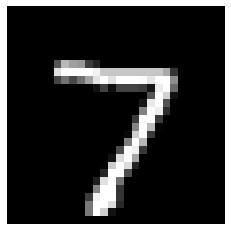

In [104]:
plt.imshow(x_test[0].reshape(28,28).astype(np.float), cmap='gray');plt.axis("off");plt.show()

<h3> Firstly, feed image to the <b>head</b> model. Then feed the output prediction of the head into the <b>tail</b> model.

<h3> At last, Let's see whether the final prediction is correct?! </h3>

In [105]:
# Create batch size 1
tst = np.expand_dims(x_test[0], 0)

# Do inference by head model
head_pred = head.predict(tst)
print("Output shape of the head model: ",head_pred.shape)

# Do inference by tail model
tail_pred = tail.predict(head_pred)
print("Output shape of the tail model: ",tail_pred.shape)

# Check whether the output is correct or not.
print("Predicted Label:", np.argmax(tail_pred))

Output shape of the head model:  (1, 9, 9, 32)
Output shape of the tail model:  (1, 10)
Predicted Label: 7


<h1 dir='rtl' align='center'>YUP :D</h1>

<h3> Save splitted models </h3>


In [106]:
head.save("head_model", save_format='tf')
tail.save("tail_model", save_format='tf')

INFO:tensorflow:Assets written to: head_model/assets
INFO:tensorflow:Assets written to: tail_model/assets


<h2> Merge Head and Tail <h2>

<h3> Merging these two seperated models is too simple! </h3>

In [107]:
merged_model = keras.Sequential([head, tail], name="merged_model")
merged_model.summary()


Model: "merged_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
head_model (Functional)      (None, 9, 9, 32)          42496     
_________________________________________________________________
tail_model (Functional)      (None, 10)                683722    
Total params: 726,218
Trainable params: 725,738
Non-trainable params: 480
_________________________________________________________________


<h2> Practice: </h2>



1.   The model below is a VGG-style model designed for MNIST dataset. Split it into two parts.
2.   Split a model into more than two parts.



In [ ]:

# Design a VGG-like digit recognition model
model = keras.Sequential(
    [
      keras.Input(shape=input_shape, name="input"),
      KL.Dropout(0.001, name="drop_0"),
      KL.experimental.preprocessing.RandomZoom((-factor, factor), name="zoom"),
      KL.experimental.preprocessing.RandomTranslation((-factor, factor), (-factor, factor), name="translate"),
      KL.experimental.preprocessing.RandomRotation((-factor, factor), name="rotate"),
      KL.experimental.preprocessing.RandomContrast(factor, name="contrast"),
     
      KL.Conv2D(32, kernel_size=(3, 3), strides=(1,1), name="conv_1"),
      KL.BatchNormalization(name="bn_1"),
      KL.Activation(tf.nn.relu6, name="act_1"),
      # KL.Lambda(relu6, name="act_1"),
      KL.Dropout(0.2, name="drop_1"),
      KL.Conv2D(64, kernel_size=(3, 3), strides=(1, 1), name="conv_2"),
      KL.BatchNormalization(name="bn_2"),
      KL.Activation(tf.nn.relu6, name="act_2"),
      KL.MaxPooling2D(pool_size=(2, 2), name="split"),

      KL.Flatten(name="flatten"),
      KL.Dropout(0.25, name="drop_3"),
      KL.Dense(64, activation="relu", name="dense_1"),
      KL.Dropout(.2, name="drop_4"),
      KL.Dense(num_classes, activation="softmax", name="output"),
    ]
)

# Print a summary of the model
# model.summary(line_length=150)


<h1> END! </h1>

Any kind of contribution is appreciated.

Github: [github.com/nrasadi/split-keras-tensorflow-model](https://github.com/nrasadi/split-keras-tensorflow-model)